In [1]:
import h5py, os
from functions import transforms as T
from functions.subsample import MaskFunc

import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader

In [2]:
def show_slices(data, slice_nums, cmap=None): # visualisation
    fig = plt.figure(figsize=(15,10))
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)
        plt.axis('off')

In [3]:
class MRIDataset(DataLoader):
    def __init__(self, data_list, acceleration, center_fraction, use_seed):
        self.data_list = data_list # data list imported to be processed
        self.acceleration = acceleration # defined AF
        self.center_fraction = center_fraction # defined CF
        self.use_seed = use_seed # defined random or stable mask

    def __len__(self): # create an attribute of the length of dataset
        return len(self.data_list) # 

    def __getitem__(self, idx): # 
        subject_id = self.data_list[idx]
        return get_epoch_batch(subject_id, self.acceleration, self.center_fraction, self.use_seed)

In [4]:
def get_epoch_batch(subject_id, acc, center_fract, use_seed=True):
    ''' random select a few slices (batch_size) from each volume'''

    fname, rawdata_name, slice = subject_id  
    
    with h5py.File(rawdata_name, 'r') as data:
        rawdata = data['kspace'][slice]
                      
    slice_kspace = T.to_tensor(rawdata).unsqueeze(0)
    S, Ny, Nx, ps = slice_kspace.shape

    # apply random mask
    shape = np.array(slice_kspace.shape)
    mask_func = MaskFunc(center_fractions=[center_fract], accelerations=[acc])
    seed = None if not use_seed else tuple(map(ord, fname))
    mask = mask_func(shape, seed)
      
    # undersample
    masked_kspace = torch.where(mask == 0, torch.Tensor([0]), slice_kspace)
    masks = mask.repeat(S, Ny, 1, ps)

    img_gt, img_und = T.ifft2(slice_kspace), T.ifft2(masked_kspace)

    # perform data normalization which is important for network to learn useful features
    # during inference there is no ground truth image so use the zero-filled recon to normalize
    norm = T.complex_abs(img_und).max()
    if norm < 1e-6: norm = 1e-6
    
    # normalized data
    img_gt, img_und, rawdata_und = img_gt/norm, img_und/norm, masked_kspace/norm
        
    return img_gt.squeeze(0), img_und.squeeze(0), rawdata_und.squeeze(0), masks.squeeze(0), norm

In [42]:
def load_data_path(train_data_path, val_data_path):
    """ Go through each subset (training, validation) and list all 
    the file names, the file paths and the slices of subjects in the training and validation sets 
    """

    data_list = {} # initiate the data list
    train_and_val = ['train', 'val'] # set the keys in data list
    data_path = [train_data_path, val_data_path] # import the data path for both training and validation
      
    for i in range(len(data_path)): # iterate on both paths

        data_list[train_and_val[i]] = [] # reset the data list 
        
        which_data_path = data_path[i] # set the data path to current dataset
    
        for fname in sorted(os.listdir(which_data_path)): # iterate on all listed files in the data path
            
            subject_data_path = os.path.join(which_data_path, fname) # set subject data path with its directory
                     
            if not os.path.isfile(subject_data_path): continue # iterate until all files are registered on path
            
            with h5py.File(subject_data_path, 'r') as data: # open the subject at the desinated path
                num_slice = data['kspace'].shape[0] # set # of slices as the 1st-D of the data's kspace data
                
            # the first 5 slices are mostly noise so it is better to exlude them
            data_list[train_and_val[i]] += [(fname, subject_data_path, slice) for slice in range(5, num_slice)]
            # data_list is concatenated by a list each consisted with a file's name, path and slices excluding 
            # the first 5 slices that are  mostly considered as noise 
            
    return data_list # {'train': [('file1000000.h5','/home/kevinxu/Documents/NC2019MRI/train/file1000000.h5',5)

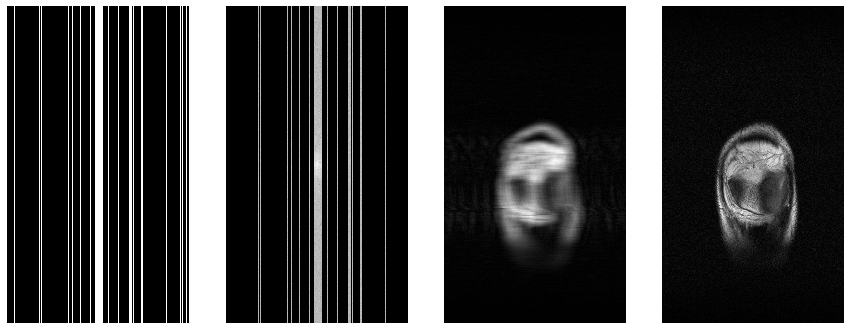

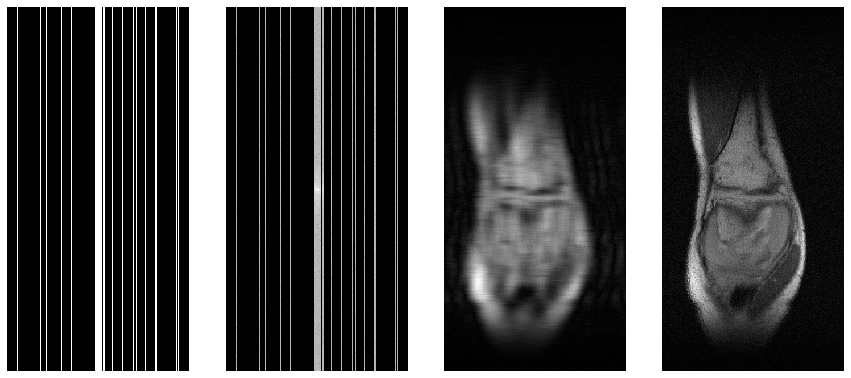

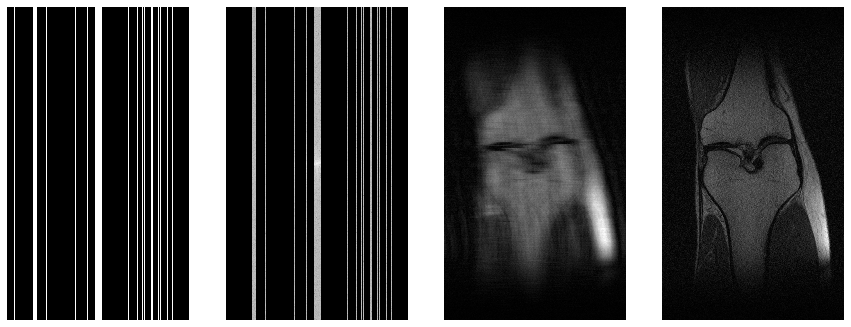

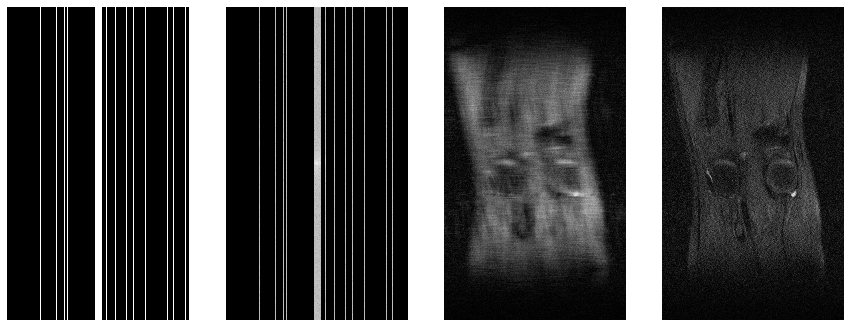

In [28]:
if __name__ == '__main__': # main() function of the file
    
    data_path_train = '/home/kevinxu/Documents/NC2019MRI/train'
    data_path_val = '/home/kevinxu/Documents/NC2019MRI/train'
    data_list = load_data_path(data_path_train, data_path_val) # first load all file names, paths and slices.

    acc = 8 # AF
    cen_fract = 0.04 # central fraction that are set to be included
    seed = False # random masks for each slice 
    num_batch = 1 # batch size of each loading process
    num_workers = 12 # data loading is faster using a bigger number for num_workers. 0 means using cpu.
    
    # create data loader for training set. It applies same to validation set as well
    train_dataset = MRIDataset(data_list['train'], acceleration=acc, center_fraction=cen_fract, use_seed=seed)
    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=num_batch, num_workers=num_workers) 
    for iteration, sample in enumerate(train_loader):
        
        img_gt, img_und, rawdata_und, masks, norm = sample
         
        # stack different slices into a volume for visualisation
        A = masks[...,0].squeeze()    # mask applied
        B = torch.log(T.complex_abs(rawdata_und) + 1e-9).squeeze()    # masked kspace image
        C = T.complex_abs(img_und).squeeze()    # image generated from under-sampled data
        D = T.complex_abs(img_gt).squeeze()    # image generated from ground truth data
        all_imgs = torch.stack([A,B,C,D], dim=0)

        # from left to right: mask, masked kspace, undersampled image, ground truth
        show_slices(all_imgs, [0, 1, 2, 3], cmap='gray')
        plt.pause(0.1)

        if iteration >= 3: break  # show 4 random slices

In [6]:
class ConvBlock(nn.Module):
    """
    A Convolutional Block that consists of two convolution layers each followed by
    instance normalization, relu activation and dropout.
    """

    def __init__(self, in_chans, out_chans, drop_prob):
        """
        Args:
            in_chans (int): Number of channels in the input.
            out_chans (int): Number of channels in the output.
            drop_prob (float): Dropout probability.
        """
        super().__init__()

        self.in_chans = in_chans
        self.out_chans = out_chans
        self.drop_prob = drop_prob

        self.layers = nn.Sequential(
            nn.Conv2d(in_chans, out_chans, kernel_size=3, padding=1),
            nn.InstanceNorm2d(out_chans),
            nn.ReLU(),
            nn.Dropout2d(drop_prob),
            nn.Conv2d(out_chans, out_chans, kernel_size=3, padding=1),
            nn.InstanceNorm2d(out_chans),
            nn.ReLU(),
            nn.Dropout2d(drop_prob)
        )

    def forward(self, input):
        """
        Args:
            input (torch.Tensor): Input tensor of shape [batch_size, self.in_chans, height, width]

        Returns:
            (torch.Tensor): Output tensor of shape [batch_size, self.out_chans, height, width]
        """
        return self.layers(input)

    def __repr__(self):
        return f'ConvBlock(in_chans={self.in_chans}, out_chans={self.out_chans}, ' \
            f'drop_prob={self.drop_prob})'


class UnetModel(nn.Module):
    """
    PyTorch implementation of a U-Net model.

    This is based on:
        Olaf Ronneberger, Philipp Fischer, and Thomas Brox. U-net: Convolutional networks
        for biomedical image segmentation. In International Conference on Medical image
        computing and computer-assisted intervention, pages 234â€“241. Springer, 2015.
    """

    def __init__(self, in_chans, out_chans, chans, num_pool_layers, drop_prob):
        """
        Args:
            in_chans (int): Number of channels in the input to the U-Net model.
            out_chans (int): Number of channels in the output to the U-Net model.
            chans (int): Number of output channels of the first convolution layer.
            num_pool_layers (int): Number of down-sampling and up-sampling layers.
            drop_prob (float): Dropout probability.
        """
        super().__init__()

        self.in_chans = in_chans
        self.out_chans = out_chans
        self.chans = chans
        self.num_pool_layers = num_pool_layers
        self.drop_prob = drop_prob

        self.down_sample_layers = nn.ModuleList([ConvBlock(in_chans, chans, drop_prob)])
        ch = chans
        for i in range(num_pool_layers - 1):
            self.down_sample_layers += [ConvBlock(ch, ch * 2, drop_prob)]
            ch *= 2
        self.conv = ConvBlock(ch, ch, drop_prob)

        self.up_sample_layers = nn.ModuleList()
        for i in range(num_pool_layers - 1):
            self.up_sample_layers += [ConvBlock(ch * 2, ch // 2, drop_prob)]
            ch //= 2
        self.up_sample_layers += [ConvBlock(ch * 2, ch, drop_prob)]
        self.conv2 = nn.Sequential(
            nn.Conv2d(ch, ch // 2, kernel_size=1),
            nn.Conv2d(ch // 2, out_chans, kernel_size=1),
            nn.Conv2d(out_chans, out_chans, kernel_size=1),
        )

    def forward(self, input):
        """
        Args:
            input (torch.Tensor): Input tensor of shape [batch_size, self.in_chans, height, width]

        Returns:
            (torch.Tensor): Output tensor of shape [batch_size, self.out_chans, height, width]
        """
        stack = []
        output = input
        # Apply down-sampling layers
        for layer in self.down_sample_layers:
            output = layer(output)
            stack.append(output)
            output = F.max_pool2d(output, kernel_size=2)

        output = self.conv(output)

        # Apply up-sampling layers
        for layer in self.up_sample_layers:
            output = F.interpolate(output, scale_factor=2, mode='bilinear', align_corners=False)
            output = torch.cat([output, stack.pop()], dim=1)
            output = layer(output)
        return self.conv2(output)


In [45]:
MRIDataset.len

AttributeError: type object 'MRIDataset' has no attribute 'len'